# **GE - TP: Segmentation with PyTorch**

In this TP, we will code a U-Net like deep neural network to perform segmentation of tumours in brain images.

# **1. Imports**

In [7]:
# !python3 -m pip install -U scikit-image
import torch
import torch.nn as nn
import torch.utils.data
import torch.utils.tensorboard
import torchvision
import torchvision.transforms
import os
import time
import numpy as np
# import skimage.transform
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection as model_selection
from tqdm import tqdm
from glob import glob
from IPython.display import clear_output

# !pip install SimpleITK
import SimpleITK as sitk

# !pip install tensorboard

# **2. Database**



## 2.a. Download the database

Run the following cell to download the database.

In [8]:
!git clone https://github.com/soniamartinot/GEP1.git

Cloning into 'GEP1'...
remote: Enumerating objects: 105007, done.
error: RPC failed; curl 56 GnuTLS recv error (-54): Error in the pull function.
fatal: the remote end hung up unexpectedly
fatal: early EOF
fatal: index-pack failed


## 2.b. Overview of the database

The data is stored in the folder `/GEP1/`.

In that folder you will find:
> The `origin_data` folder: contains 4 patients. 
>- For each patient, you will find a whole volume per modality in nifti format.
>- Each volume has a shape `(155, 192, 192)`

> The `data` folder: contains 336 patients. 
>- Images in that folder have underwent some preprocessing and have now a shape `(78, 96, 96)`. This will make training of deep learning models faster and less greedy memory-wise.
>- For a patient `BraTS19_EXAMPLE`, you will have a corresponding folder `/GEP1/data/BraTS19_EXAMPLE`. Inside this folder, you will have nifti files (`.nii.gz`) for each modality and each z slice. . 
>- There are 78 slices per volume, i.e. 78 slices per modality.



In [6]:
# The data is store in the folder /GEP1/
data_path = './GEP1/data/'
original_data_path = './GEP1/origin_data/'

### **i. Inside of the database**

In [7]:
# Original data
print("Content of the folder:\n", os.listdir(original_data_path))
patient = "BraTS19_TCIA01_131_1"
print("Content of a patient's folder:\n", os.listdir(original_data_path + patient))

Content of the folder:
 ['BraTS19_TCIA10_442_1', 'BraTS19_CBICA_AWV_1', 'BraTS19_TCIA01_131_1', 'BraTS19_CBICA_ANP_1']
Content of a patient's folder:
 ['BraTS19_TCIA01_131_1_seg.nii.gz', 'BraTS19_TCIA01_131_1_t1.nii.gz', 'BraTS19_TCIA01_131_1_t1ce.nii.gz', 'BraTS19_TCIA01_131_1_t2.nii.gz', 'BraTS19_TCIA01_131_1_flair.nii.gz']


In [8]:
# Processed data
files = os.listdir(data_path) # All the files in the folder /GEP1/data/
print('Content of the folder {} \n: {}'.format(data_path, files[:5]))
print('Number of files for each patient : {}'.format(len(os.listdir(data_path + files[0])) ))
print('Number of patients in {} : {}'.format(data_path, len(files)))

Content of the folder ./GEP1/data/ 
: ['BraTS19_CBICA_APK_1', 'BraTS19_CBICA_AUA_1', 'BraTS19_CBICA_ABM_1', 'BraTS19_TCIA03_133_1', 'BraTS19_CBICA_BBG_1']
Number of files for each patient : 390
Number of patients in ./GEP1/data/ : 336


### **ii. Inside of a patient's folder**

For each patient, we have 4 modalities and the segmentation:

- t1
- t2
- flair
- t1ce (gado)
- segmentation
    
For each modality, you also have a file for each slice along the Z axis.

Each patient has **78 slices** per modality.

In [ ]:
modalities = ['t1', 't2', 't1ce', 'flair', 'seg']

In [ ]:
patient = 'BraTS19_2013_20_1'
patient_path = os.path.join(data_path, patient)
patient_files = os.listdir(patient_path)
patient_files[:10]

In [ ]:
""" 
Filter for the Flair modality 
"""

flair_modality_files = sorted([e for e in patient_files if 'flair' in e])
print("Number of Z slices:", len(flair_modality_files))
flair_modality_files[-5:]

### **iii. SimpleITK tutorial**

We use the `SimpleITK` Python package in order to read the nifti files of the database. 

To open a a nifti image:

        image = sitk.ReadImage(image_path)

Using this package, you can access relevant and physical information about the image:
- spacing: `image.GetSpacing()`
- direction: `image.GetDirection()`
- origin: `image.GetOrigin()`
- size: `image.GetSize()`
- metadata: `image.GetMetaDataKeys()`
- access the value of a pixel: `image.GetPixel(pixel_x, pixel_y, pixel_z)`

You can also convert the `sitk` image into a `numpy` array:

        array = sitk.GetArrayFromImage(image)

In [ ]:
patient = 'BraTS19_CBICA_ANP_1'

# Define the image path
z = 3
modality = 'flair'
patient_folder = os.path.join(original_data_path, patient) 
image_name = "{patient}_{modality}.nii.gz".format(patient=patient, modality=modality)
image_path = os.path.join(patient_folder, image_name)
print("Path to the image:", image_path) 
# We use the librairy sitk to open the nifti images
image = sitk.ReadImage(image_path)
print("Type of the opened image:", type(image))

In [ ]:
# Print geometrical information
print('Image Direction : {}'.format("""Complete here"""))
print('Image Spacing : {}'.format("""Complete here"""))
print('Image Origin : {}'.format("""Complete here"""))
print('Image Size : {}'.format("""Complete here"""))
print('Pixel value:', """Complete here""")

In [ ]:
# Get all the information in the meta data
keys = """Complete here"""
print('Metadata:')
for key in keys:
    print('{} : {}'.format(key, """Complete here"""))

In [ ]:
# Convert the sitk image 
array = """Complete here"""
print("Type of the image:", type(array)) # Type of the image
print("Shape of the image as a numpy array:", array.shape)
print("Value of the first pixel of the numpy array:", array[0, 0, 0])

### **iv. Comparison between original data and preprocessed data.**

In order to accelerate the calculation time and have good results quickly, the original images of the dataset of shape `(155, 240, 240)` have been preprocessed according to the following steps:
- Cropped the images to a shape of `(155, 192, 192)`
- Downsampled the images by interpolation of scale 0.5 (https://scikit-image.org/docs/dev/auto_examples/transform/plot_rescale.html) to a shape of `(78, 96, 96)`
- Saved all the Z slices **independently** in a new array of shape `(96, 96)`



In [ ]:
patient = 'BraTS19_CBICA_ANP_1'

# Define the image path in the original data
z = 3
modality = 'flair'
patient_folder = os.path.join(original_data_path, patient) 
image_name = "{patient}_{modality}.nii.gz".format(patient=patient, modality=modality)
image_path = os.path.join(patient_folder, image_name)

# We use the librairy sitk to open the nifti images
image = sitk.ReadImage(image_path)

orig_array = """Complete here"""

print('Original array shape : {}'.format(orig_array.shape))

# open corresponding preprocessed data slice
patient_folder = os.path.join(data_path, patient)
z_slice = 35
path = os.path.join(patient_folder, "{patient}_{modality}_z_{z_slice}.nii.gz".format(patient=patient, modality=modality, z_slice=z_slice))
processed_image = sitk.ReadImage(path)

processed_array = """Complete here"""

print('Processed array shape : {}'.format(processed_array.shape))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(orig_array[z_slice*2, :, :], cmap='gray')
plt.title('Original array')
plt.subplot(1, 2, 2)
plt.imshow(processed_array, cmap='gray')
plt.title('Processed array')
plt.show()

### **v. Visualize all modalities**

Consider a patient in the `data` folder. Plot each modality side by side, by iterating over the number of slices.

In [ ]:
# Go over each Z slice
for z in range(0, len(flair_modality_files), 10):
    f, axes = plt.subplots(1, 5, figsize=(20, 6))
    
    # Plot each modality for that slice
    for i, modality in enumerate(modalities):

        
        # Fetch the modality-slice file and open using SimpleITK
        file_path = """Complete here"""
        slice = """Complete here"""
        
        # Plot the slice
        axes[i].set_title(modality)
        axes[i].imshow(slice, cmap="gray")
        
    plt.suptitle("Slice {}/{}".format(z+1, len(flair_modality_files)), y=0.85)
    plt.show()
    clear_output(wait=True)

## 2.c. Creating the train, validation and test sets


The train, validation and test split are stored in the folder `/GEP1/datasets`. For each split, you will have a text file indicating the list of patients.

Execute the following code to :
*   Load the train, validation and test set.
*   Print the first 5 patients of the train set.
*   Print the length of the train, validation and test set.


In [ ]:
datasets_path = './GEP1/datasets/'

train_set = np.loadtxt(datasets_path + 'train.txt', dtype=str)
validation_set = np.loadtxt(datasets_path + 'val.txt', dtype=str)
test_set = np.loadtxt(datasets_path + 'test.txt', dtype=str)

# Train_set, validation_set and test_set are list of patients
print('Train set, first 5 patients : {}\n'.format(train_set[:5])) # Print the first 5 patients of train_set
print('Train set length :\t {}'.format(len(train_set)))
print('Validation set length :\t {}'.format(len(validation_set)))
print('Test set length :\t {}'.format(len(test_set)))

# **3. Creation of the deep convolutional neural network**

In this part, we will implement and train a [**UNet**](https://arxiv.org/pdf/1505.04597.pdf). UNets are particularly used for segmentation tasks in medical imaging. You can study its architecture in the following figure.

The UNet has two main features : 

1.   The size of the input image is downsampled by 2 at each block by a layer called `MaxPooling` in the **encoder part** of the model. In the **decoder part**, extracted features are upsampled progressively using a Transpose Convolution  (`ConvTranspose2d` in PyTorch).

2.   Secondly in order to keep information of high resolution, we use **skip-connections** to pass information from the encoder part of the network to the decoder part.

![](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)



## 3.a. Create the network


### **i. Building blocks**

What does the `get_activation` function do ?

In [ ]:
def get_activation(activation_type):
    activation_type = activation_type.lower()
    if hasattr(nn, activation_type):  return getattr(nn, activation_type)()
    else:  return nn.ReLU()

>Complete the class `ConvBatchNorm`. You should use:
>- `get_activation`
>- `BatchNorm2d`
>- `Conv2d`

In [ ]:
class ConvBatchNorm(nn.Module):
    """This block implements the sequence: (convolution => [BN] => ReLU)"""  
    def __init__(self, in_channels, out_channels, activation='ReLU'):
        super(ConvBatchNorm, self).__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, 
                              kernel_size=3, padding=1)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = get_activation(activation)
      
    def forward(self, x):
        out_conv = self.conv(x)
        out_norm = self.norm(out_conv)
        out_activation = self.activation(out_norm)
        return out_activation
    

In [ ]:
batch_conv = ConvBatchNorm(2, 64)
x = torch.rand((1, 2, 1024, 1024))

y = batch_conv(x)
y.shape

What does the function `_make_nConv` do ?

In [ ]:
def _make_nConv(in_channels, out_channels, nb_Conv, activation='ReLU'):
    layers = []
    layers.append(ConvBatchNorm(in_channels, out_channels, activation))
    for _ in range(nb_Conv-1):
        layers.append(ConvBatchNorm(out_channels, out_channels, activation))
    return nn.Sequential(*layers)

>Complete the classes:
>- `ConvBatchNorm`
>- `DownConvBlock`: these will be used to build the **encoder** part of the UNet.
>- `UpConvBlock`: these are used to build the **decoder** part of the UNet. 

>You should use PyTorch layers such as:
>- `MaxPool2d`, 
>- `ConvTransposed2d` or `Upsample`, 
>- `ReLU`.

In [ ]:
class DownBlock(nn.Module):
    """Downscaling with maxpooling and convolutions"""
    def __init__(self, in_channels, out_channels, nb_Conv, activation='ReLU'):
        super(DownBlock, self).__init__()

        self.maxpool = nn.MaxPool2d(2)
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x):
        out_maxpool = """Complete here"""
        out_nconvs = """Complete here"""
        return out_nconvs

class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(Bottleneck, self).__init__()
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)


    def forward(self, input):
        out = self.nConvs(input)
        return out

class UpBlock(nn.Module):
    """Upscaling then conv"""
    def __init__(self, in_channels, out_channels, nb_Conv=2, activation='ReLU'):
        super(UpBlock, self).__init__()      

        self.up = """Complete here"""
        self.nConvs = _make_nConv(in_channels, out_channels, nb_Conv, activation)

    def forward(self, x, skip_x):

        out_up = """Complete here"""

        # Skip connection (use torch.cat function)
        x = """Complete here"""
        return self.nConvs(x)

### **ii. UNet architecture**

Here you will use the building blocks coded above to construct the full UNet architecture.

- Be careful to the number of input / output channels of each block when implementing the skip connections. 

- Try to compare the following code with the figure. Where are the `DownConvBlock`, the `UpConvBlock` ?

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels=4, n_classes=4):
        '''
        n_channels : number of channels of the input. 
                        By default 4, because we have 4 modalities
        n_labels : number of channels of the ouput.
                      By default 4 (3 labels + 1 for the background)
        '''
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Question here
        self.inc = ConvBatchNorm(n_channels, 64)
        self.down1 =  """Complete here"""

        self.Encoder = [self.down1, self.down2, self.down3, self.down4]

        self.bottleneck = Bottleneck(512, 512)

        self.up1 = """Complete here"""

        self.Decoder = [self.up1, self.up2, self.up3]

        self.outc = nn.Sequential(nn.ConvTranspose2d(64, 64, 
                                                     kernel_size=3, stride=2, 
                                                     padding=1, output_padding=1),
                                  nn.Conv2d(64, self.n_classes, kernel_size=3, stride=1, padding=1)
                                  )
        self.last_activation = get_activation('Softmax')

    
    def forward(self, x):
        # Forward 
        skip_inputs = []
        x = self.inc(x) 

        # Forward through encoder
        for i, block in enumerate(self.Encoder):
            x = block(x)  
            skip_inputs += [x] 
#             print(x.shape)             

        # We are at the bottleneck.
        bottleneck = self.bottleneck(x)

        # Forward through decoder
        skip_inputs.reverse()

        decoded = bottleneck
        for i, block in enumerate(self.Decoder):
            # Concat with skipconnections
            skipped = skip_inputs[i+1]
#             print(skipped.shape, decoded.shape)
            decoded = block(decoded, skipped)
        out = self.last_activation(self.outc(decoded))
        return out

## 3.b. Study the model 

> To study and debug a neural network, you can try to feed a random tensor of size `(1, 4, 96, 96)` (batch size, number of modalites, image shape) using the `torch.rand` function.

> The output's shape should be the same as the input.

> To better debug, you may need to modify your code to take a look at the output shape of each layer in your network .



In [ ]:
model = UNet(n_channels=4, n_classes=4)
print(model)

# Image of size 96*96 with 4 modality + batch size = 1
x = torch.rand((1, 4, 96, 96))  # Batch Size x N Modalités x H x W
y = model(x)
print(y.shape)

UNet(
  (inc): ConvBatchNorm(
    (conv): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
  )
  (down2): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(

# **4. Dataset creation**



## 4.a. Helper functions

Check and study the following code

In [ ]:
end = '.nii.gz'
seg_name = '_seg'

def load_split(split_folder):
    '''
        return train, val, test split with loadtxt
    '''
    train_split = np.loadtxt(os.path.join(
        split_folder, 'train.txt'), dtype=str)
    val_split = np.loadtxt(os.path.join(split_folder, 'val.txt'), dtype=str)
    test_split = np.loadtxt(os.path.join(split_folder, 'test.txt'), dtype=str)
    return train_split, val_split, test_split


def load_sitk(path):
    return sitk.GetArrayFromImage(sitk.ReadImage(path))


def find_z_slice(list_patient, threshold, dataframe):
    """
    For each patient in list_patient, this function returns the list of slices where 
    the corresponding image is not empty"""
    
    list_IDs = []
    for patient in list_patient:
        if threshold > 0:
            condition = dataframe[patient].values >= threshold
            z_slice = np.where(condition)[0]
        else:
            z_slice = range(155)
        list_IDs += list(set([(patient, int(z//2)) for z in z_slice]))

    return list_IDs


def generate_IDs(train_split, val_split, test_split,
                 tumor_percentage, csv_path, image_size=(240, 240)):

    tumor_volume_dataframe = pd.read_csv(csv_path)
    threshold = int(tumor_percentage * np.prod(image_size) / 100)
    
    train_IDs, val_IDs, test_IDs = [], [], []
    train_IDs = find_z_slice(train_split, threshold, tumor_volume_dataframe)
    val_IDs = find_z_slice(val_split, threshold, tumor_volume_dataframe)
    test_IDs = find_z_slice(test_split, 0, tumor_volume_dataframe)
    return train_IDs, val_IDs, test_IDs


def to_var(x, device):
    if isinstance(x, np.ndarray):
        x = torch.from_numpy(x)
    x = x.to(device)
    return x

def to_numpy(x):
    if not (isinstance(x, np.ndarray) or x is None):
        if x.is_cuda: 
            x = x.data.cpu()
        x = x.numpy()
    return x

def save_checkpoint(state, save_path):
    '''
        Save the current model. 
        If the model is the best model since beginning of the training
        it will be copy
    '''

    if not os.path.isdir(save_path):
        os.makedirs(save_path)

    epoch = state['epoch']
    val_loss = state['val_loss']
    filename = save_path + '/' + \
        'model.{:02d}--{:.3f}.pth.tar'.format(epoch, val_loss)
    torch.save(state, filename)


def print_summary(epoch, i, nb_batch, loss, batch_time, 
                  average_loss, average_time, mode):
    '''
        mode = Train or Test
    '''
    summary = '[' + str(mode) + '] Epoch: [{0}][{1}/{2}]\t'.format(
        epoch, i, nb_batch)

    string = ''
    string += ('Dice Loss {:.4f} ').format(loss)
    string += ('(Average {:.4f}) \t').format(average_loss)
    string += ('Batch Time {:.4f} ').format(batch_time)
    string += ('(Average {:.4f}) \t').format(average_time)

    summary += string
    print(summary)
    
def plot(irms, masks=None, pred_masks=None):
    
    kwargs = {'cmap': 'gray'}
    fig, ax = plt.subplots(2, 3, gridspec_kw={'wspace': 0.15, 'hspace': 0.2,
                                              'top': 0.85, 'bottom': 0.1,
                                              'left': 0.05, 'right': 0.95},
                           figsize=(12, 7))        
    ax[0, 0].imshow(irms[0, :, :], **kwargs)
    
    if masks is not None:
        masks = np.argmax(masks, axis=0)
        ax[0, 1].imshow(masks, vmin=0, vmax=3)
        
    if pred_masks is not None:
        pred_masks = np.argmax(pred_masks, axis=0)
        ax[0, 2].imshow(pred_masks, vmin=0, vmax=3)

    for i in range(3):
        ax[1, i].imshow(irms[i+1, :, :], **kwargs)

    for i in range(2):
        for j in range(3):
            ax[i, j].grid(False)
            ax[i, j].axis('off')
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])

    ax[0, 0].set_title('IRM T1')
    ax[1, 0].set_title('IRM Gado')
    ax[1, 1].set_title('IRM T2')
    ax[1, 2].set_title('IRM Flair')    
    ax[0, 1].set_title('Ground Truth Seg')
    ax[0, 2].set_title('Predicted Seg')
    fig.canvas.draw()
    
    return fig


## 4.b. Dataset class

In [ ]:
class SegmentationDataset(torch.utils.data.Dataset):
    'Generates data for torch'

    def __init__(self, files_list, data_path, modalities=['t1', 't2', 't1ce', 'flair'], transform=None):
        super(SegmentationDataset, self).__init__()
        self.files_list = files_list
        self.transform = transform
        self.data_path = data_path
        self.modalities = modalities

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        'Get a patient given idx'
        patient = self.files_list[idx]

        # Load the patient's modalities and segmentation masks
        irm, mask = self.load(patient)
        sample = (irm, mask)

        # Apply data transformation
        if self.transform:
            irm, mask = self.transform(sample)
        return (irm, mask, patient)

    def load(self, ID):

        patient, z_slice = ID
        patient_path = os.path.join(self.data_path, patient)

        # Get all modalities for the given slice
        irm = []
        for modality in self.modalities:
            file_name = "{patient}_{modality}_z_{z_slice}.nii.gz".format(patient=patient, modality=modality, z_slice=z_slice)
            path = os.path.join(patient_path, file_name)
            irm.append(load_sitk(path))
        irm = np.stack(irm, axis=0)

        # Get the segmentation mask for the given slice
        seg_name = "{patient}_seg_z_{z_slice}.nii.gz".format(patient=patient, z_slice=z_slice)
        mask_path = os.path.join(patient_path, seg_name)
        mask = load_sitk(mask_path)
        mask[mask == 4] = 3
        
        # Convert segmentation mask to one-hot encoding
        label = 4
        mask = mask.astype(np.int16)
        mask = np.rollaxis(np.eye(label, dtype=np.uint8)[mask], -1, 0)
        return irm, mask

## 4.c. Creating the split and generating the slice indexes lists

`train_IDs`, `val_IDs` and `test_IDs` are the arguments that are passed as `files_list` when creating an instance of the `SegmentationDataset` class.

In [ ]:
# Load the split, generate the IDs list 
datasets_path ='./GEP1/datasets/' 
csv_path = './GEP1/data/tumor_count.csv'

# The tumour percentage is the percentage of tumour in an image. It's a threshold
# that is used when selecting relevant slice indexes in a patient's images.
tumour_percentage = 0.5
train_split, val_split, test_split = load_split(datasets_path)

(train_IDs, val_IDs, test_IDs) = generate_IDs(train_split, val_split, test_split, tumour_percentage, csv_path)

In [ ]:
val_IDs[:5]

[('BraTS19_TCIA01_499_1', 23),
 ('BraTS19_TCIA01_499_1', 20),
 ('BraTS19_TCIA01_499_1', 26),
 ('BraTS19_TCIA01_499_1', 29),
 ('BraTS19_TCIA01_499_1', 35)]

## 4.d. Creating instances of the `SegmentationDataset` class for each split

In [ ]:
# No data augmentation implemented yet.
transformation=None
data_path = './GEP1/data/'

train_Dataset = """Complete here"""

val_Dataset = """Complete here"""

test_Dataset = """Complete here"""
        

The following cell calls for a sample of the training set. Running `train_Dataset[0]` actually calls the `__getitem__` method of the `SegmentationDataset` class.

In [ ]:
input_modalities, segmentation_mask, patient = train_Dataset[0]

In [ ]:
print("Shape of the input:", input_modalities.shape)
print("Shape of the segmentation masks:", segmentation_mask.shape)
print("Patient identification:", patient[0])
print("Selected slice:", patient[1])

Shape of the input: (4, 96, 96)
Shape of the segmentation masks: (4, 96, 96)
Patient identification: BraTS19_CBICA_BHQ_1
Selected slice: 41


## 4.e. Create the `DataLoader` that will be used during training


Use the class `torch.utils.data.DataLoader`.

For each split, you need to specify:
- the batch size with the `batch_size` argument
- whether to shuffle your dataset when feeding batches to the model using the `shuffle` argument
- whether to drop the last incomplete batch, if the dataset size is not divisible by the batch size, using the `drop_last` argument. This parameter is particularly useful when working with multiprocessing (`num_workers` > 1).

In [ ]:
# Define the batch size
batch_size = 64


train_loader = """Complete here"""

val_loader = """Complete here"""

test_loader = """Complete here"""   

# **5. Training**

## 5.a. Loss function, optimizer and hyperparameters

Here you need to choose:
- the loss function used to optimize the model (see [here](https://pytorch.org/docs/stable/nn.html#loss-functions)),
- the optimizer (see [here](https://pytorch.org/docs/stable/optim.html))
- all the hyperparameters: learning rate, weight decay ...


>In our application, you can start by :
>- choosing the `Adam` optimizer
>- coding your own custom loss function as the dice loss

In [ ]:
def dice_loss(input, target):
    smooth = 1.
    target = target.float()
    input = input.float()
    input_flat = input.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    intersection = (input_flat * target_flat).sum()
    return 1 - ((2. * intersection + smooth) /
                (input_flat.pow(2).sum() + target_flat.pow(2).sum() + smooth))

def mean_dice_loss(input, target):  
    channels = list(range(target.shape[1]))
    loss = 0
    for channel in channels:
        dice = dice_loss(input[:, channel, ...],
                         target[:, channel, ...])
        loss += dice
    return loss / len(channels)


In [ ]:
learning_rate = 1e-3

criterion = dice_loss # Choose loss function
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Choose optimize

## 5.b. Instantiate your model

You need to specify:
- the number of input channels of the model `n_channels` which should be equal to the number of modalities, so 4 modalities
- the number of segmentation classes `n_classes` = 4

In [ ]:
n_modalities = 4
n_classes = 4

In [ ]:
torch.cuda.set_device(3)

model = """Complete here"""# Create model
model.cuda() # move model to GPU

UNet(
  (inc): ConvBatchNorm(
    (conv): Conv2d(4, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): ReLU()
  )
  (down1): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(
      (0): ConvBatchNorm(
        (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (1): ConvBatchNorm(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
    )
  )
  (down2): DownBlock(
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (nConvs): Sequential(

## 5.c. Training loop for a single epoch

Here you should complete the `train_loop` function, which goes over the whole dataset only once, so correspond to one epoch.

When the model is in training mode `model.training == True`, the function should perform backpropagation and parameters' updates.

In [ ]:
# Train the model
def train_loop(loader, model, criterion, optimizer, writer, epoch):

    logging_mode = 'Train' if model.training else 'Val'
    
    
    epoch_time_sum, epoch_loss_sum = [], []
    
    for i, sample in enumerate(loader, 1):
        start = time.time()
        # Take variable 
        (irms, masks, patients) = sample
        # print(irms.shape) # Batch * Number of Modalities * Width * Height

        # Put variables to GPU
        irms = irms.float().cuda()
        masks = masks.float().cuda()
    
        # compute model prediction
        pred_masks = """Complete here"""

        # compute loss
        dice_loss = """Complete here"""

        # If in training mode ...
        if model.training:
            # Initialize optimizer gradients to zero
            """Complete here"""
            # Perform backpropagation
            """Complete here"""
            # Update the model's trainable parameters using the computed gradients
            """Complete here"""

        # Compute elapsed time
        batch_time = time.time() - start

        epoch_time_sum += [batch_time]
        epoch_loss_sum += [dice_loss.item()]
        
        average_time = np.mean(epoch_time_sum)
        average_loss = np.mean(epoch_loss_sum)
        
        if i % print_frequency == 0:
            print_summary(epoch + 1, i, len(loader), dice_loss, batch_time,
                          average_loss, average_time, logging_mode)
        step = epoch*len(loader) + i
        writer.add_scalar(logging_mode + '_dice', dice_loss.item(),step)
            
            

    writer.add_scalar(logging_mode + '_global_loss', np.mean(epoch_loss_sum), epoch)


    # Save some figures to monitor segmentation quality
    n_modalities = irms.shape[0]
    irms = to_numpy(irms)
    masks = to_numpy(masks)
    pred_masks = to_numpy(pred_masks)

    for batch in range(n_modalities):
        fig = plot(irms[batch, ...], masks[batch, ...], pred_masks[batch, ...])        
        writer.add_figure(logging_mode + str(batch), fig, epoch)
    writer.flush()
    return np.mean(epoch_loss_sum)

## 5.d. Do the training

You will use **Tensorboard** to monitor the decrease of the loss funciton/

In [ ]:
save_path = "./GEP1/save/"
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
model_path = save_path + 'models/' + session_name + '/'

In [ ]:
# Start tensorboard
session_name = 'Test_session' + '_' + time.strftime('%m.%d %Hh%M')
tensorboard_folder = save_path + 'tensorboard_logs/'
log_dir = tensorboard_folder + session_name + '/'

if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = torch.utils.tensorboard.SummaryWriter(log_dir)

In [ ]:
epochs =  """Complete here"""
print_frequency = 10
save_frequency = 10
save_model = True

In [ ]:
for epoch in range(epochs):  # loop over the dataset multiple times
    print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))
    print(session_name)

    # train for one epoch
    model.train()
    print('Training')

    train_loss = """Complete here"""

    # evaluate on validation set
    print('Validation')
    with torch.no_grad():   # Disable gradient computation (faster and saves memory)
        model.eval()        # Disable Dropout and BatchNormalization
        
        val_loss = """Complete here"""

    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                        'state_dict': model.state_dict(),
                         'val_loss': val_loss,
                         'optimizer': optimizer.state_dict()}, model_path)
        

******** Epoch [1/6]  ********
Test_session_10.06 18h24
Training
[Train] Epoch: [1][5/106]	Dice Loss 0.2488 (Average 0.2554) 	Batch Time 0.0586 (Average 0.0484) 	
[Train] Epoch: [1][10/106]	Dice Loss 0.2303 (Average 0.2524) 	Batch Time 0.0568 (Average 0.0529) 	
[Train] Epoch: [1][15/106]	Dice Loss 0.2391 (Average 0.2508) 	Batch Time 0.0580 (Average 0.0545) 	
[Train] Epoch: [1][20/106]	Dice Loss 0.2609 (Average 0.2522) 	Batch Time 0.0575 (Average 0.0552) 	
[Train] Epoch: [1][25/106]	Dice Loss 0.2221 (Average 0.2506) 	Batch Time 0.0566 (Average 0.0557) 	
[Train] Epoch: [1][30/106]	Dice Loss 0.2215 (Average 0.2464) 	Batch Time 0.0575 (Average 0.0561) 	
[Train] Epoch: [1][35/106]	Dice Loss 0.2058 (Average 0.2445) 	Batch Time 0.0571 (Average 0.0563) 	
[Train] Epoch: [1][40/106]	Dice Loss 0.2444 (Average 0.2418) 	Batch Time 0.0561 (Average 0.0563) 	
[Train] Epoch: [1][45/106]	Dice Loss 0.2157 (Average 0.2397) 	Batch Time 0.0577 (Average 0.0564) 	
[Train] Epoch: [1][50/106]	Dice Loss 0.2647 (

# **6. Prediction and Evaluation**

After training the model we have to perform two steps : 
 

1.  Using the trained model to predict a segmentation.
 
2.  Evaluate the network's performance on the test set.

The evaluation of the network should be done on test set which has not been seen during training.

The validation set used during training was useful only to manage overfitting / underfitting issues and to assess the generalization ability of the model.





## 6.a. Prediction and returning to original space
In this exercice:
>- we will load a network and use the function `predict()` to predict a segmentation. 
>- The predicted segmentation will have a shape `(96, 96, 4)`. 
>- We need to transform it back to the 3D shape `(155, 240, 240)` to perform the evaluation against the complete data.

The steps to compute the prediction will be : 

- Apply `predict()` function on a dataloader, with a model. We don't need to calculate the loss and backpropagate them. 
- Apply `reconstruct_patient()` to find and save in the good order all the slice corresponding to one patient.
- Apply `get_mask2original_shape()` to the prediction to go from a shape `(78, 4, 96, 96)` to `(155, 240, 240)`

**Questions**
- Complete the `predict()` function
- Study the function `get_mask2original_shape()`. What are doing the different functions inside it ? Try to guess the different shapes



In [ ]:
def predict(loader, model, batch_size=1):
    preds = {}
    for i, sample in tqdm(enumerate(loader, 1)):
        # Take variable and put them to GPU
        (irms, masks, patients) = sample

        irms = """Complete here"""
        masks = """Complete here"""
        
        batch_patient_names, batch_z_slices = patients[0], patients[1]
    
        # compute output
        pred_masks = """Complete here"""

        # Put the predictions in a dictionnary with one key being the 
        # patient and the z slice
        n_batch = len(pred_masks)
        for j in range(n_batch):
            patient, z_slice = batch_patient_names[j], batch_z_slices[j]
            name = patient + '_z_' + str(to_numpy(z_slice))
            preds[name] = to_numpy(pred_masks[j])
    return preds

def reconstruct_patient(preds, patient, z_max = 78):
    '''
    From the dictionnary with prediction find the slice corresponding to 
    one patient and construct a 3D matrix of shape 77*96*96
    '''
    X = []
    for i in range(z_max):
        name = patient + '_z_' + str(i)
        array_slice = preds[name]
        X.append(array_slice)
    X = np.stack(X, axis=0) 
    return X


def get_mask2original_shape(predict_mask):
    mask = np.zeros(shape=(155,240, 240))
    res = skimage.transform.resize(predict_mask, (155, 4, 192, 192))
    res = res > 0.5
    res = np.argmax(res, axis=1)
    mask[:, 24:-24, 24:-24] = res
    mask[mask == 3] = 4
    return mask.astype('int')

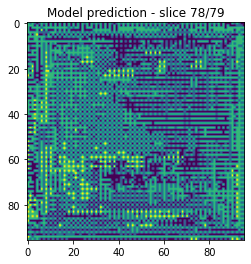

Mask shape: (78, 4, 96, 96)
Resized mask shape: (155, 240, 240)


In [ ]:
test_path = original_data_path
patients = [os.path.basename(p) for p in glob(test_path + "*")]
patient = patients[0]

model.eval()
# Make prediction
with torch.no_grad():
    preds = """Complete here"""

# reconstruct the patient's complete volume
predict_mask = """Complete here"""

# for i in range(len(predict_mask)):
#     plt.figure()
#     plt.title("Model prediction - slice {}/{}".format(i+1, len(predict_mask)+1))
#     plt.imshow(np.argmax(predict_mask[i, ...], axis=0))
#     plt.show()
#     clear_output(wait=True)

i = int(len(predict_mask))
plt.figure()
plt.title("Model prediction - slice {}/{}".format(i+1, len(predict_mask)+1))
plt.imshow(np.argmax(predict_mask[i, ...], axis=0))
plt.show()
clear_output(wait=True)

print("Mask shape:", predict_mask.shape)

# Return to original shape
predict_mask = """Complete here"""


print("Resized mask shape:", predict_mask.shape)


## 6.b. Visual Comparaison

We will do a visual comparison between the predicted segmentation and the ground-truth segmentation. 

**Questions**
- Load the ground-truth segmentation (in folder `/GEP1/origin_data`) and using the function `plt.subplot`, `plt.imshow` and `plt.title`, plot the predicted mask and the groundtruth side by side
- Change the value of the `z_slice` parameter to explore the segmentation slice by slice
- Study the function `numpy2nifti`. What does it do ? Apply it and save the predicted mask as a nifti files. 

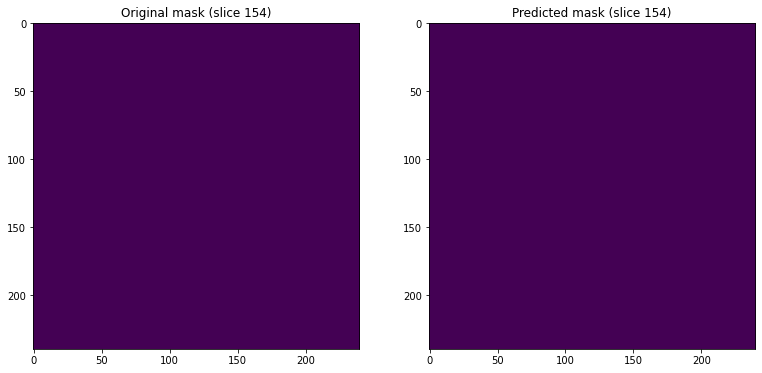

In [ ]:
# Compare visual plot of prediction and original mask 
import matplotlib.pyplot as plt

patient_folder = os.path.join(test_path, patient)
orig_image = sitk.ReadImage(os.path.join(patient_folder, patient  + '_seg.nii.gz' ))
orig_mask = sitk.GetArrayFromImage(orig_image)

z_slice=100
for z_slice in range(orig_mask.shape[0]):
    plt.figure(figsize=(13, 6))
    plt.subplot(1,2,1)
    plt.imshow(orig_mask[z_slice, :,: ], vmin=0, vmax=4)
    plt.title('Original mask (slice {})'.format(z_slice))

    plt.subplot(1,2,2)
    plt.imshow(predict_mask[z_slice, :,: ], vmin=0, vmax=4)
    plt.title('Predicted mask (slice {})'.format(z_slice))
    plt.show()
    clear_output(wait=True)

In [ ]:
def numpy2sitk(predict_mask, orig_img):
    '''
    Input : predict_mask of type numpy array
            orig_img of type SimpleITK image
    Output : new_img of type SimpleITK image 
    '''
    new_img = sitk.GetImageFromArray(predict_mask)
    new_img.SetDirection(orig_img.GetDirection())
    new_img.SetOrigin(orig_img.GetOrigin())
    new_img.SetSpacing(orig_img.GetSpacing())
    return new_img

predict_img = numpy2sitk(predict_mask, orig_image)
path = os.path.join(patient_folder, patient + '_predict_seg.nii.gz')
sitk.WriteImage(predict_img, path)

## 6.c. Metrics 


We will now compute the evaluation metrics to assess the performance of our model. 

We will use 3 metrics : 
- the sensitivity (also called true positive rate), 
- the specificity (also called true negative rate) 
- the dice score (different of the dice loss used during the training). 

We will evaluate the metrics on the 5 patients in the folder `/GEP1/origin_data`. In the reality, we should evaluate the metrics for all the patients of the test set.

**Questions :**
- Complete the `metrics()` function in order to calculate the Dice, Sensitivity and Specificity.
- Using the previous `predict_mask` and `orig_mask` array, compute the metrics. You just need to apply the function `evalAllSample()`. Print the result. 
- Using, a for loop and all the functions defined in the part 3, calculate the metrics for the patients in the folder `/GEP1/origin_dat`a. You should print the average Dice value for each category (WT, ET, TC)




In [ ]:
import pandas as pd

def metrics(mask_, gt_):
    '''
    Taking to binary array of same shape as input
    This function compute the confusion matrix and use it to calculate 
    Dice metrics, Sensitivity and Specificity
    Input : mask_, gt_ numpy array of identic shape (only 1 and 0)
    Output : List of 3 scores
    '''
    lnot = np.logical_not
    land = np.logical_and

    true_positive = np.sum(land((mask_), (gt_)))
    false_positive = np.sum(land((mask_), lnot(gt_)))
    false_negative = np.sum(land(lnot(mask_), (gt_)))
    true_negative = np.sum(land(lnot(mask_), lnot(gt_)))

    M = np.array([[true_negative, false_negative],
                [false_positive, true_positive]]).astype(np.float64)
    metrics = {}
    metrics['Sensitivity'] = """Complete here"""
    metrics['Specificity'] = """Complete here"""
    metrics['Dice'] =  """Complete here"""

    
    # metrics may be NaN if denominator is zero! use np.nanmean() while
    # computing average to ignore NaNs.

    return [metrics['Dice'], metrics['Sensitivity'], metrics['Specificity']]


def evalAllSample(mask_, gt_):
    '''
    This functions takes as input two numpy arrays with labels between
    0, 1, 2 and 4 and calculate the metrics as defined in BraTS data challenge
    mask_ and gt_ should be array of int
    '''
    # whole tumor (labels 1,2,4)
    mask_wt, gt_wt = (np.array([0, 1, 1, 0, 1])[mask_], 
                    np.array([0, 1, 1, 0, 1])[gt_])
    wt_metrics = metrics(mask_wt, gt_wt)

    # tumor core (labels 1,4)
    mask_tc, gt_tc = (np.array([0, 1, 0, 0, 1])[mask_], 
                    np.array([0, 1, 0, 0, 1])[gt_])
    tc_metrics = metrics(mask_tc, gt_tc)

    # enhancing tumor (label 4)
    mask_et, gt_et = (np.array([0, 0, 0, 0, 1])[mask_], 
                    np.array([0, 0, 0, 0, 1])[gt_])
    et_metrics = metrics(mask_et, gt_et)

    return pd.DataFrame({'wt': wt_metrics, 'tc': tc_metrics, 'et': et_metrics},
                      index=['Dice', 'Sensitivity', 'Specificity'])

In [ ]:
wt_dice_list = []
et_dice_list = []
tc_dice_list = []

model.eval()
with torch.no_grad():
    preds = predict(test_loader, model, batch_size=batch_size)

for patient in patients:
    # Path to original image
    patient_folder = os.path.join(test_path,patient)
    # Open image
    orig_image = sitk.ReadImage(os.path.join(patient_folder, 
                                            patient  + '_seg.nii.gz'))
    # Convert image to numpy array
    orig_mask = """Complete here"""
    
    # Reconstruct the whole patient predicted mask
    predict_mask = """Complete here"""
    predict_mask = """Complete here"""
    
    print('*********** {} ***********'.format(patient))
    # Use the evalAllSamples function to evaluate model
    scores = """Complete here"""
    print(scores)
    print("\n")

    wt_dice_list.append(scores.loc['Dice', 'wt'])
    et_dice_list.append(scores.loc['Dice', 'et'])
    tc_dice_list.append(scores.loc['Dice', 'tc'])

3276it [00:44, 73.61it/s]


*********** BraTS19_TCIA01_131_1 ***********
                   wt        tc        et
Dice         0.760534  0.824802  0.745901
Sensitivity  0.697605  0.708131  0.611964
Specificity  0.999417  0.999988  0.999971


*********** BraTS19_TCIA10_442_1 ***********
                   wt        tc        et
Dice         0.627759  0.304091  0.635871
Sensitivity  0.464006  0.179335  0.840426
Specificity  0.999813  0.999998  0.999806


*********** BraTS19_CBICA_ANP_1 ***********
                   wt        tc        et
Dice         0.625351  0.587809  0.553887
Sensitivity  0.520103  0.637033  0.609440
Specificity  0.999272  0.999879  0.999888


*********** BraTS19_CBICA_AWV_1 ***********
                   wt        tc        et
Dice         0.546221  0.605168  0.490454
Sensitivity  0.412998  0.437648  0.343872
Specificity  0.999731  0.999986  0.999951




In [ ]:
print('Whole Tumor Dice : {:.2f}'.format(np.mean(wt_dice_list)))
print('Tumor Core Dice : {:.2f}'.format(np.mean(et_dice_list)))
print('Enhancing Tumor Dice : {:.2f}'.format(np.mean(tc_dice_list)))

Whole Tumor Dice : 0.64
Tumor Core Dice : 0.61
Enhancing Tumor Dice : 0.58


# **7. Data Augmentation**
 In this part, we will use data augmentation to better the performance of the model. Because convolutional neural networks are only invariant with regards to translation, the idea of data augmentation is to create new artificial samples so that the network see more data and overfits less, thus increasing its generalization power.



In [ ]:
import scipy
import scipy.ndimage
import numpy as np

class AxialFlip(object):

    def __call__(self, sample):
        choice_x = np.random.randint(0, 2)
        choice_y = np.random.randint(0, 2)        
        irm, mask = sample
        new_sample = (self.axialflip(irm, choice_x, choice_y),
                      self.axialflip(mask, choice_x, choice_y))
        return new_sample

    def axialflip(self, array, choice_x, choice_y):
        if choice_x == 1:  array = array[:, ::-1, :]
        if choice_y == 1:  array = array[:, ::-1, ::-1]
        return np.ascontiguousarray(array)

class RandomRotation90(object):
    '''
        Taken from augment_rot90 from MIC-DKFZ/batchgenerators
        https://github.com/MIC-DKFZ/batchgenerators/blob/master/batchgenerators/augmentations/spatial_transformations.py
    '''

    def __init__(self, num_rot=(1, 2, 3, 4)):
        self.num_rot = num_rot
        self.axes = (1,2)

    def __call__(self, sample):
        '''
          irm and mask have shape (Modality*Width*Height) and (Label*Width*Height)
        '''
        num_rot = np.random.choice(self.num_rot)        
        def f(img):
            return np.ascontiguousarray(np.rot90(img, num_rot, self.axes))
        
        irm, mask = sample
        new_sample = (f(irm), f(mask))
        return new_sample

class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, cubic crop
            is made.
    """
    def __init__(self, output_size, dim=2):
        assert isinstance(output_size, (int, tuple, list))
        if isinstance(output_size, int):
            self.output_size = dim * (output_size,)
        else:
            assert len(output_size) == dim
            self.output_size = output_size  

    def __call__(self, sample):        
        irm, mask = sample        
        _, height, width = irm.shape    
        i = np.random.randint(0, height - self.output_size[0])
        j = np.random.randint(0, width - self.output_size[1])

        def f(img):
            return img[:, i: i + self.output_size[0], j : j + self.output_size[1]]

        new_sample = ( f(irm), f(mask))
        return new_sample

def RandomTranslation(max_translation=30, transform_matrix=None, debug=False):    
    translation = np.random.randint(-max_translation, max_translation, 2)    
    if debug:
        return getTranslationMatrix(translation, transform_matrix), (translation)
    else:
        return getTranslationMatrix(translation, transform_matrix)
    
def RandomRotation(theta_max=20, transform_matrix=None, debug=False):    
    theta = np.random.uniform(-theta_max, theta_max)
    if debug:
        return getRotationMatrix(theta, transform_matrix), theta
    else:
        return getRotationMatrix(theta, transform_matrix)

def RandomZoom(zoom_max=0.2, transform_matrix=None, debug=False):  
    zoom = np.random.uniform(1 - zoom_max, 1 + zoom_max)
    if debug:
          return getZoomMatrix(zoom, transform_matrix), zoom
    else:
        return getZoomMatrix(zoom, transform_matrix)

def getTranslationMatrix(translation, transform_matrix=None):
    '''
        2D translation on the axis (0, 1). 
        Axis 3 is the modality axis
        tx: Width shift.
        ty: Heigh shift.
    
    '''
    shift_matrix = np.array([[1, 0, translation[0]],
                            [0, 1, translation[1]],
                            [0, 0, 1]])

    if transform_matrix is None:
        transform_matrix = shift_matrix
    else:
        transform_matrix = np.dot(transform_matrix, shift_matrix)            
    return transform_matrix

def getZoomMatrix(zoom, transform_matrix=None):
    '''
        Affine Zoom in 2D
        zx: Zoom in x direction.
        zy: Zoom in y direction
    '''
    zoom_matrix = np.array([[zoom, 0, 0],
                            [0, zoom, 0],
                            [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = zoom_matrix
    else:
        transform_matrix = np.dot(transform_matrix, zoom_matrix)            
    return transform_matrix

def getRotationMatrix(theta, transform_matrix=None):
    '''
        2D rotation on the axis (0, 1). 
        Axis 3 is the modality axis
        theta: Rotation angle in degrees.
    '''
    theta = np.deg2rad(theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = rotation_matrix
    else:
        transform_matrix = np.dot(transform_matrix, rotation_matrix)
    return transform_matrix


def apply_affine_transform(x, seg=None, transform_matrix=None, crop_shape=None, 
                           fill_mode='nearest', cval=0., order=3):
    """Applies an affine transformation specified by the parameters given.
    # Arguments
        x: 4D numpy array, single image, multimodalities (Modality*H*W)
        fill_mode: Points outside the boundaries of the input
            are filled according to the given mode
            (one of `{'constant', 'nearest', 'reflect', 'wrap'}`).
        cval: Value used for points outside the boundaries
            of the input if `mode='constant'`.
        order: int, order of interpolation
    # Returns
        The transformed version of the input.
    """
    if scipy is None:
        raise ImportError('Image transformations require SciPy. '
                          'Install SciPy.')
    if transform_matrix is not None:        
        channels, h, w = x.shape                
        transform_matrix = transform_matrix_offset_center(transform_matrix, 
                                                          h, w)
        res = [ scipy.ndimage.affine_transform(x[channel, ...], transform_matrix,
                                              order=order, mode=fill_mode, cval=cval)  for channel in range(channels)]
        x = np.stack(res, axis=0)
        
        if seg is not None:            
            labels = seg.shape[0]
            res = [scipy.ndimage.affine_transform(seg[label, ...], transform_matrix,
                                                                order=order, mode=fill_mode, cval=cval) for label in range(labels)]
            seg = np.stack(res, axis=0)
            seg[seg > 0.5] = 1
            seg[seg < 0.5] = 0
            return x, seg         
    return x

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], 
                              [0, 1, o_y],
                              [0, 0, 1]])    
    reset_matrix = np.array([[1, 0, -o_x], 
                             [0, 1, -o_y],
                             [0, 0, 1]])    
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

class AffineTransform(object):
    
    def __init__(self, theta=0, max_translation=0, max_zoom=0):
        self.theta = theta
        self.max_translation = max_translation
        self.max_zoom = max_zoom
        
    def __call__(self, sample):        
        transform_matrix = np.eye(3)
        if self.theta > 0:
            transform_matrix = RandomRotation(self.theta)
        if self.max_translation > 0:
            transform_matrix = RandomTranslation(self.max_translation,
                                                 transform_matrix)
        if self.max_zoom > 0:
            transform_matrix = RandomZoom(self.max_zoom,
                                          transform_matrix)
        new_irm, new_mask = apply_affine_transform(irm, mask, transform_matrix)
        return (new_irm, new_mask)


## 7.a. Study of the data augmentation

Complete the following code to visualize the effect of the implemented data augmentation methods.

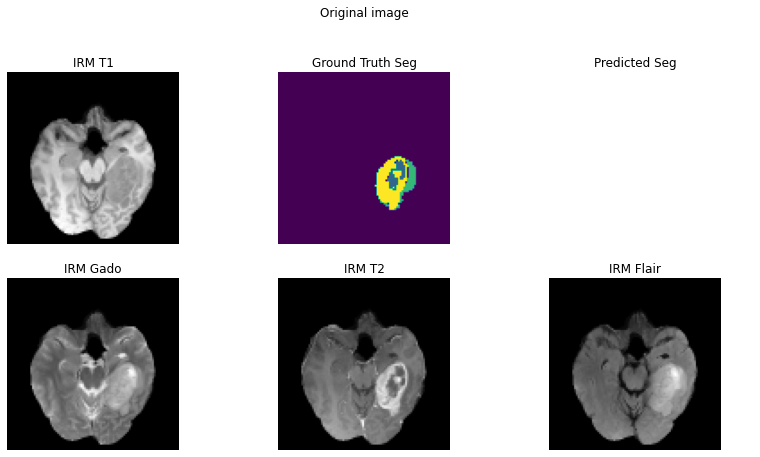

In [ ]:
k = 3

irms, masks, patient = val_loader.__iter__().next()

# irms is a list of a numpy array of shape [Batch * W*H*Modality]
irm = irms[0,:].numpy()
mask = masks[0,:].numpy()

fig = plot(irm, mask)
fig.suptitle('Original image')
fig.savefig(save_path + 'orig.png')

Axial Flip 

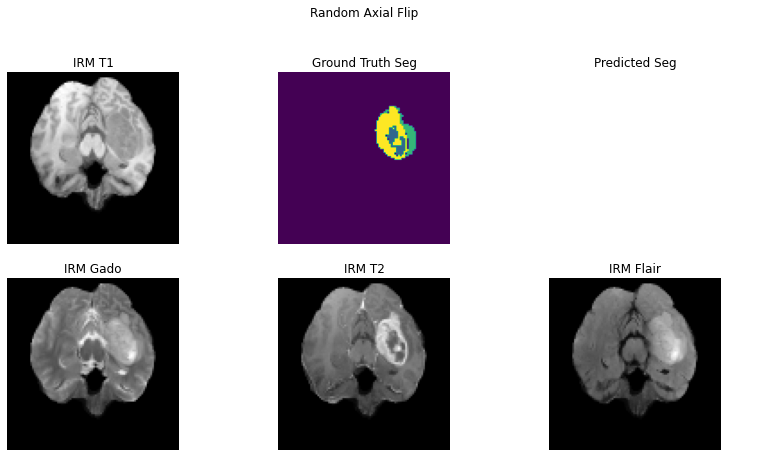

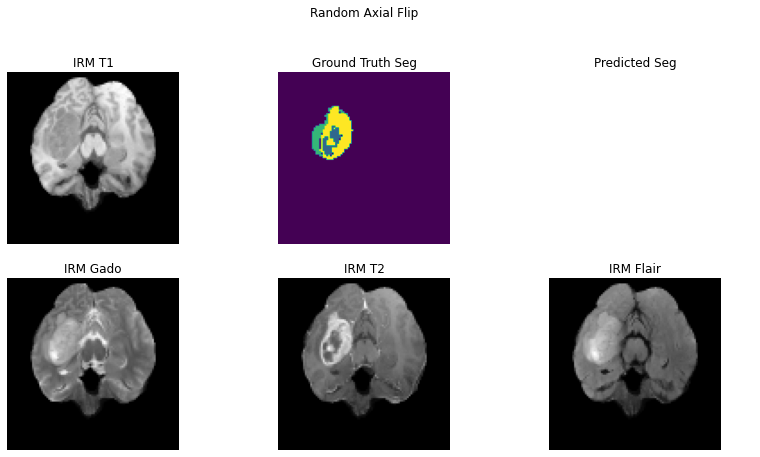

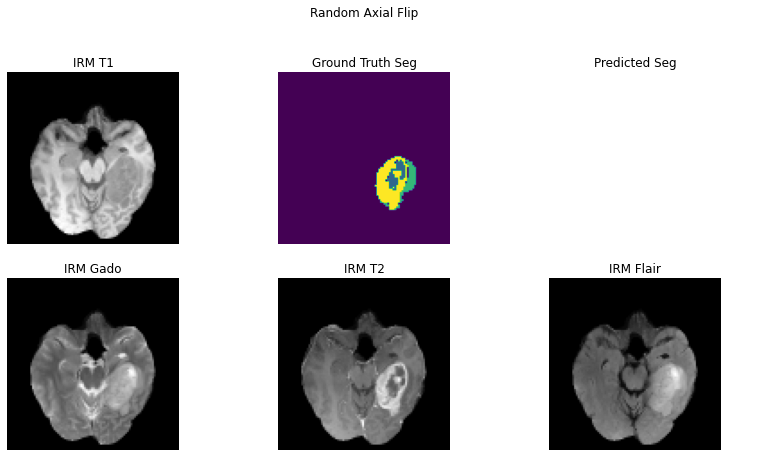

In [ ]:
flip = AxialFlip()
for i in range(k):

    (new_irm, new_mask) = flip((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random Axial Flip')
    fig.savefig(save_path + 'Axial_Flip{}.png'.format(k))

90° Rotation 

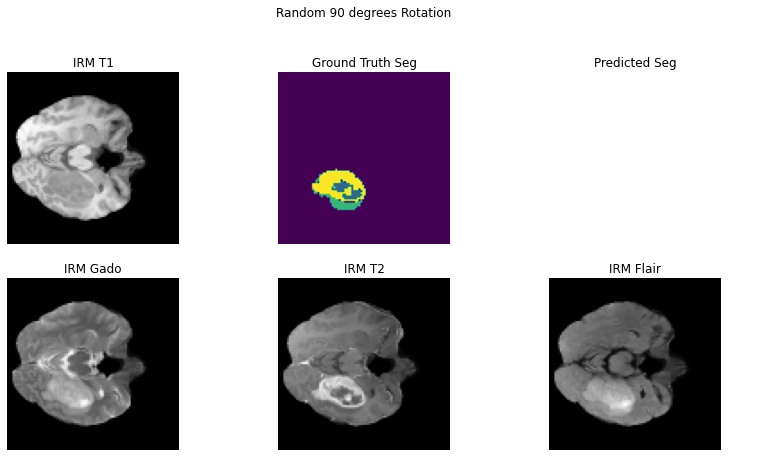

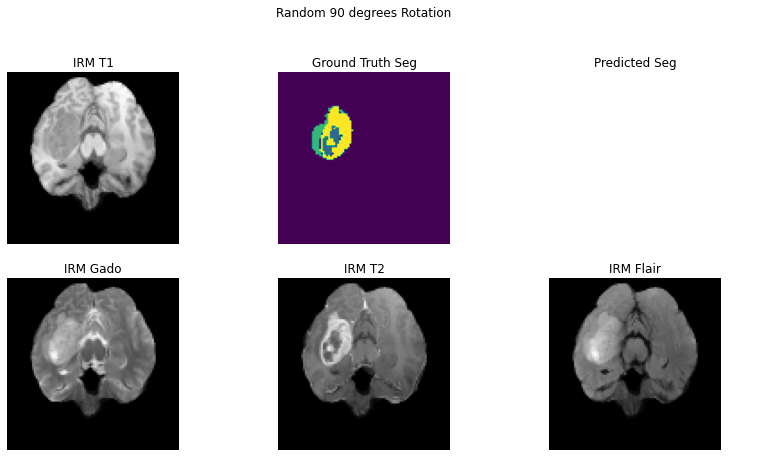

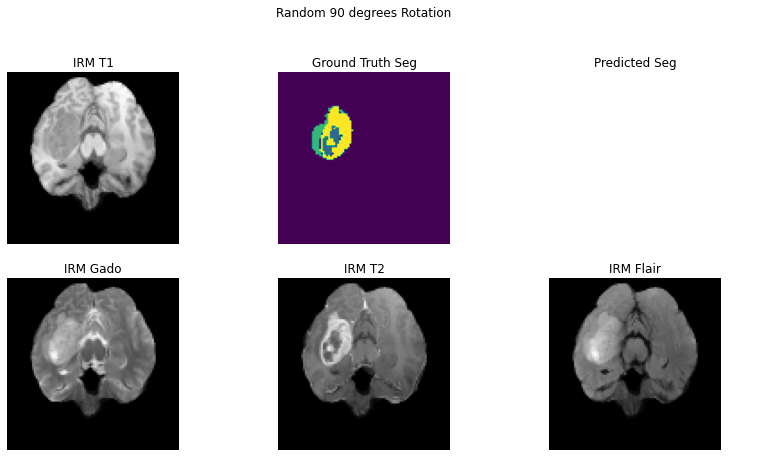

In [ ]:
random90rotation = """Complete here"""
for i in range(k):

    (new_irm, new_mask) = random90rotation((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random 90 degrees Rotation')
    fig.savefig(save_path + 'Random90Rotation{}.png'.format(k))

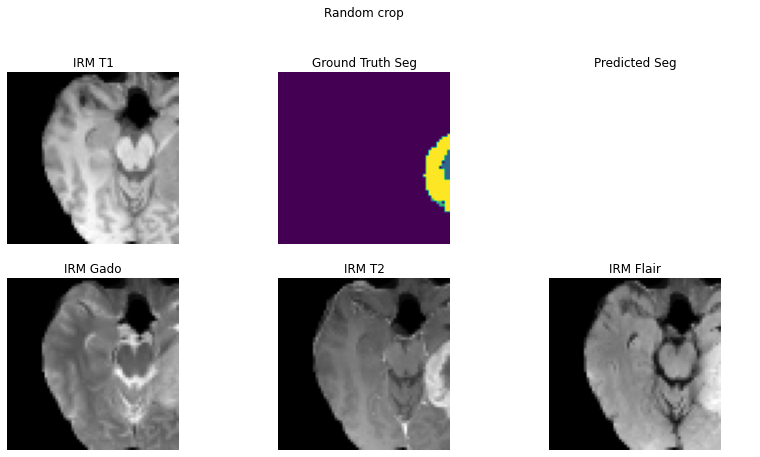

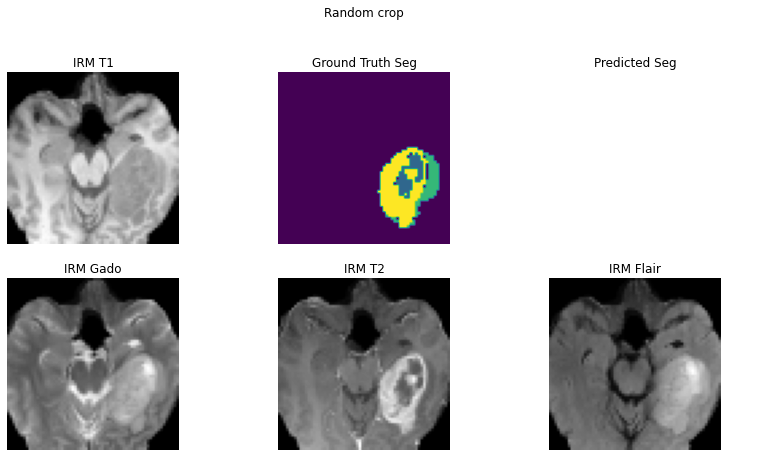

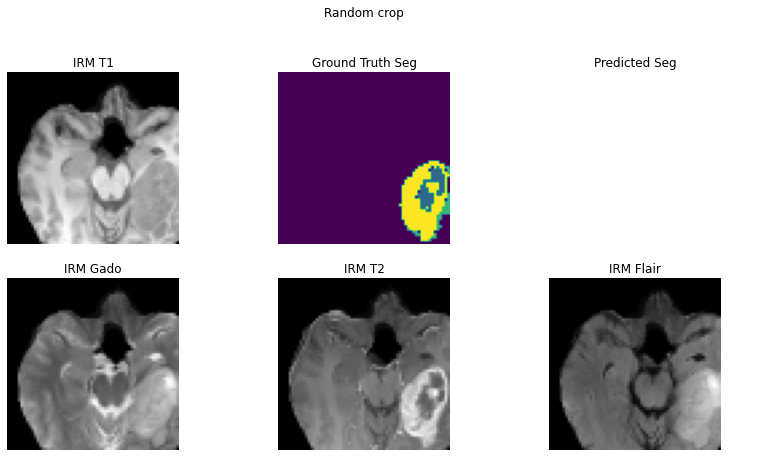

In [ ]:
randomcrop = """Complete here""" 
for i in range(k):

    (new_irm, new_mask) = """Complete here"""

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random crop')
    fig.savefig(save_path + 'Random90Rotation{}.png'.format(k))

Random Rotation with +/- 30°

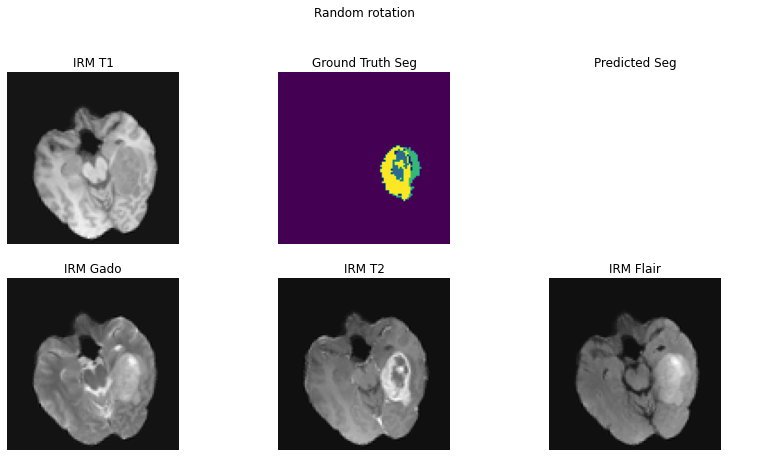

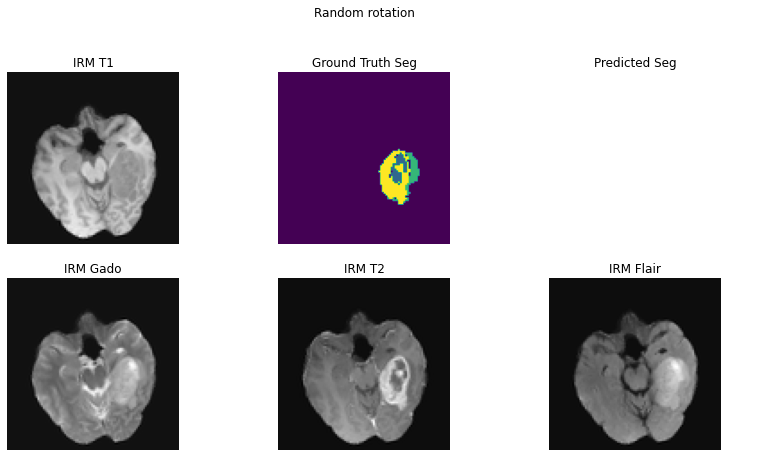

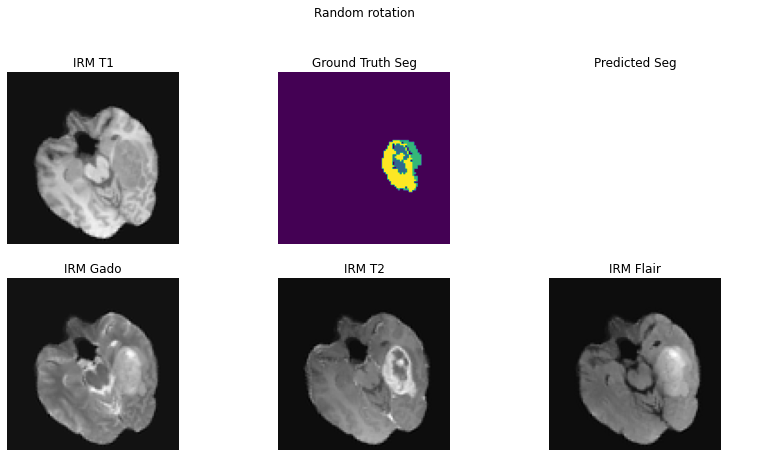

In [ ]:
rotate = """Complete here"""

for i in range(k):
    

    (new_irm, new_mask) = rotate((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random rotation')
    fig.savefig(save_path + 'Rotation{:.1f}.png'.format(i))


Random Translation 

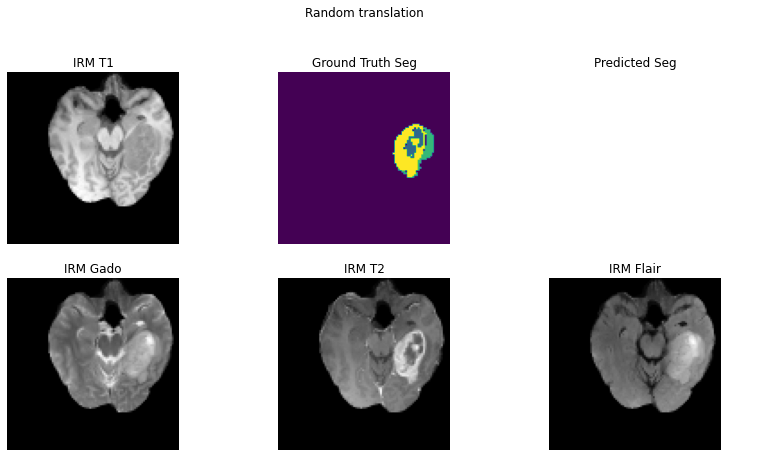

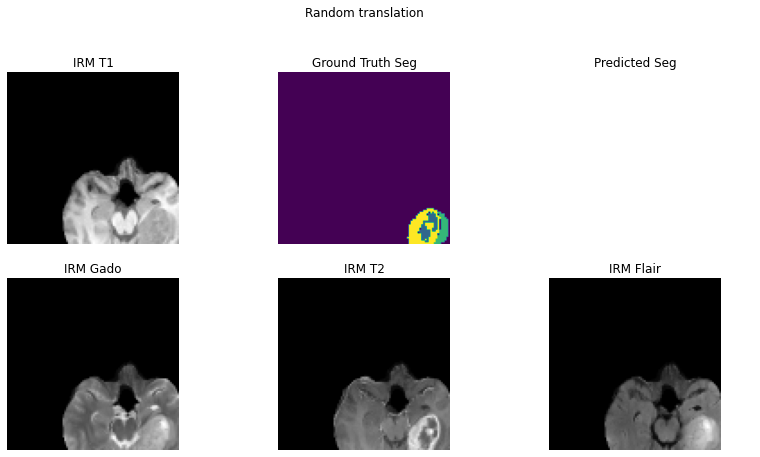

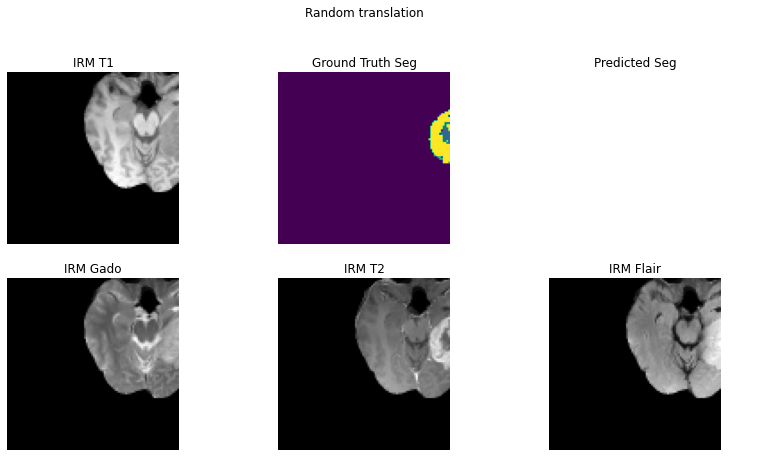

In [ ]:
translate = """Complete here"""

for i in range(k):
    new_irm, new_mask  = translate((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random translation')
    fig.savefig(save_path + 'Translation_{}.png'.format(i))

Random Zoom

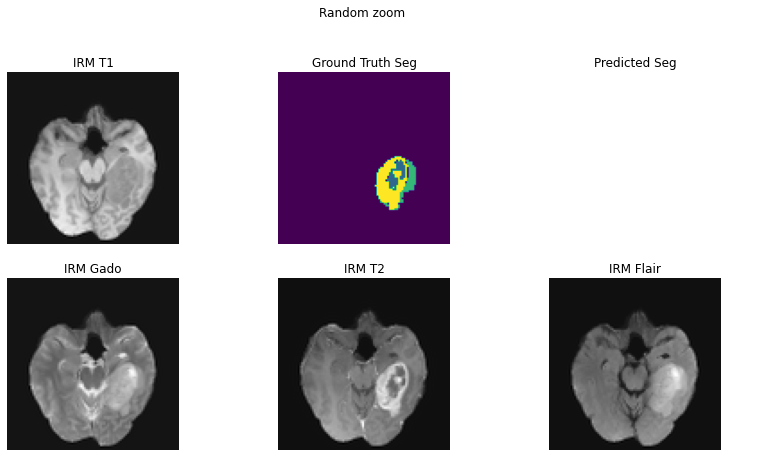

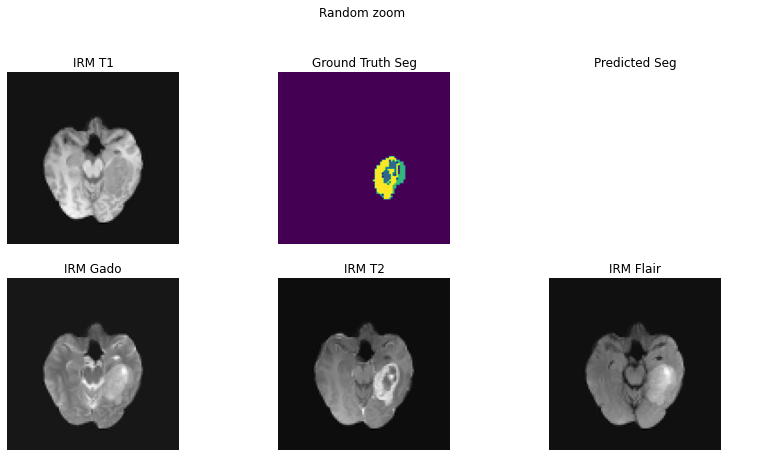

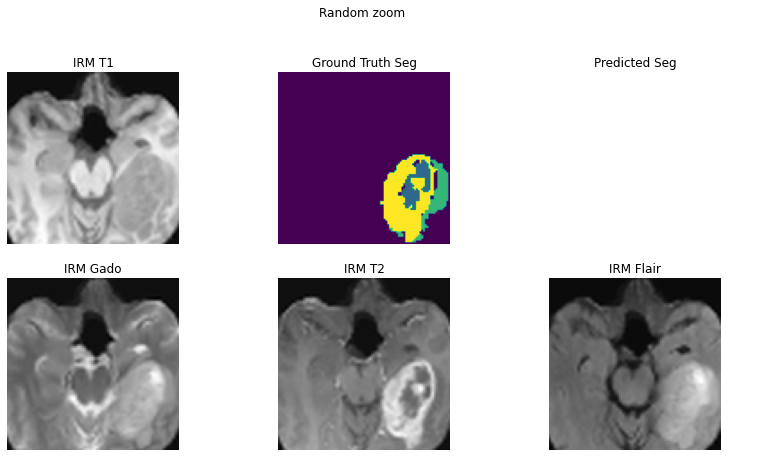

In [ ]:
zoom = """Complete here"""

for i in range(k):
    (new_irm, new_mask)  = zoom((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Random zoom ')
    fig.savefig(save_path + 'Zoom_{}.png'.format(k))

All transformations

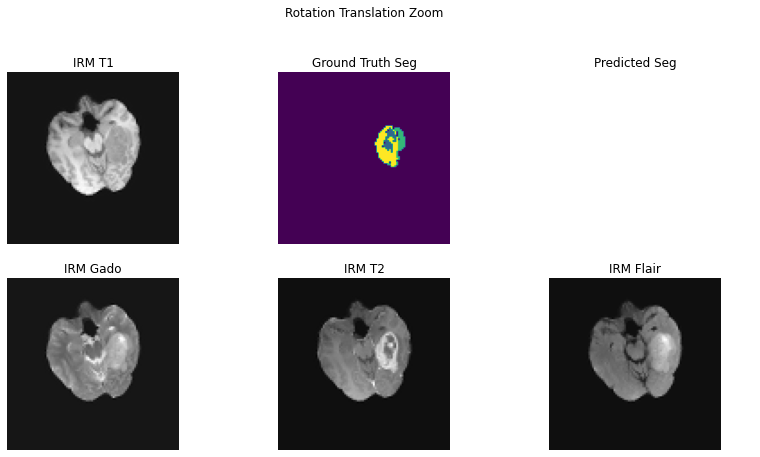

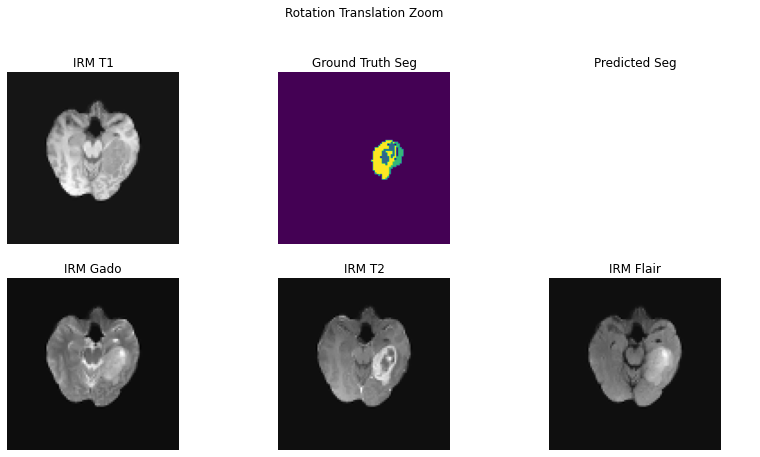

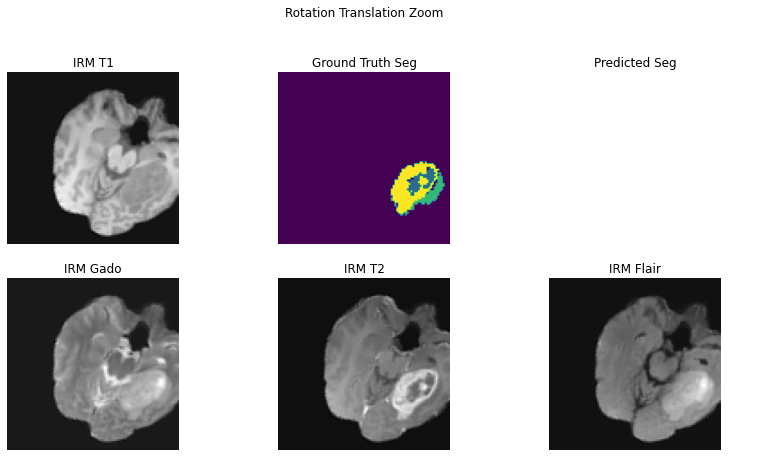

In [ ]:
affine_transform = """Complete here"""

for i in range(k):
    (new_irm, new_mask)  = affine_transform((irm, mask))

    fig = plot(new_irm, new_mask)
    fig.suptitle('Rotation Translation Zoom')
    fig.savefig(save_path + 'All_transforms{}.png'.format(i))

## 7.b. Train with data augmentation

Relaunch a new training with data augmentation. The training will take more time than the previous training.

In [ ]:
transforms_list = [AffineTransform(theta=15, max_translation=15, max_zoom=0.3),
                   AxialFlip(), RandomRotation90(), RandomCrop((64, 64))
                   ]

transformation = torchvision.transforms.Compose(transforms_list)


train_Dataset = SegmentationDataset(train_IDs, data_path=data_path,
                                    transform=transformation
                                    )

val_Dataset = SegmentationDataset(val_IDs, data_path=data_path,
                                  transform=transformation
                                  )

test_Dataset = SegmentationDataset(test_IDs, data_path=data_path,
                                  transform=None
                                  )

train_loader_data_augment = torch.utils.data.DataLoader(train_Dataset, 
                                           batch_size=batch_size, shuffle=True,
                                           drop_last=True)

val_loader_data_augment = torch.utils.data.DataLoader(val_Dataset,
                                         batch_size=batch_size, drop_last=True) 

test_loader_data_augment = torch.utils.data.DataLoader(test_Dataset,
                                         batch_size=1, drop_last=False) 

In [ ]:
learning_rate = 1e-4
image_size = (96, 96)
n_modalities = 4
n_labels = 4
epochs = 10
batch_size = 64
print_frequency = 5
save_frequency = 10
save_model = True
tumor_percentage = 0.5
tensorboard = True

In [ ]:
model = """Complete here""" # Create model
model.cuda() # move model to GPU

criterion = """Complete here""" # Choose loss function
optimizer = """Complete here""" # Choose optimizer
    
# Keep logs of training metrics. To visualize with tensorbard.
log_dir = tensorboard_folder + session_name + '/'
if not os.path.isdir(log_dir):
    os.makedirs(log_dir)
writer = torch.utils.tensorboard.SummaryWriter(log_dir)

for epoch in range(epochs):  # loop over the dataset multiple times
    print('******** Epoch [{}/{}]  ********'.format(epoch+1, epochs+1))
    print(session_name)

    # train for one epoch
    model.train()
    print('Training')
    train_loop(train_loader_data_augment, model, criterion,
               optimizer, writer, epoch)

    # evaluate on validation set
    print('Validation')
    with torch.no_grad():  # Don't compute gradients
        model.eval()       # Deactivate any BarchNormalization or Dropout layer
        val_loss = train_loop(val_loader_data_augment, model, criterion,
                              optimizer, writer, epoch)
    # Save model and otpimizer states
    # Saving the optimizer state allows to do further fine tuning later.
    if save_model and epoch % save_frequency == 0:
        save_checkpoint({'epoch': epoch,
                        'state_dict': model.state_dict(),
                         'val_loss': val_loss,
                         'optimizer': optimizer.state_dict()}, model_path)
        

******** Epoch [1/11]  ********
Test_session_10.06 18h24
Training
[Train] Epoch: [1][5/106]	Dice Loss 0.6708 (Average 0.7875) 	Batch Time 0.0342 (Average 0.0411) 	
[Train] Epoch: [1][10/106]	Dice Loss 0.5332 (Average 0.6835) 	Batch Time 0.0313 (Average 0.0363) 	
[Train] Epoch: [1][15/106]	Dice Loss 0.4436 (Average 0.6148) 	Batch Time 0.0311 (Average 0.0344) 	
[Train] Epoch: [1][20/106]	Dice Loss 0.3804 (Average 0.5635) 	Batch Time 0.0308 (Average 0.0336) 	
[Train] Epoch: [1][25/106]	Dice Loss 0.3356 (Average 0.5227) 	Batch Time 0.0321 (Average 0.0331) 	
[Train] Epoch: [1][30/106]	Dice Loss 0.2863 (Average 0.4874) 	Batch Time 0.0397 (Average 0.0332) 	
[Train] Epoch: [1][35/106]	Dice Loss 0.2444 (Average 0.4551) 	Batch Time 0.0307 (Average 0.0329) 	
[Train] Epoch: [1][40/106]	Dice Loss 0.2068 (Average 0.4259) 	Batch Time 0.0316 (Average 0.0328) 	
[Train] Epoch: [1][45/106]	Dice Loss 0.1794 (Average 0.3999) 	Batch Time 0.0325 (Average 0.0328) 	
[Train] Epoch: [1][50/106]	Dice Loss 0.1597 

## 7.c. Evaluate the model trained with data augmentation

Execute the following code to evaluate your model.

3276it [00:51, 63.28it/s]


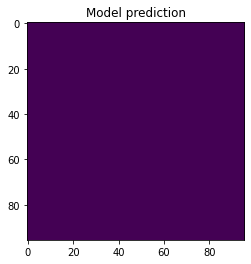

Mask shape: (78, 4, 96, 96)
Resized mask shape: (155, 240, 240)


In [ ]:
test_path = original_data_path
patients = [os.path.basename(p) for p in glob(test_path + "*")]
patient = patients[0]

model.eval()
with torch.no_grad():
    preds = predict(test_loader_data_augment, model, batch_size=batch_size)


predict_mask = reconstruct_patient(preds, patient)


plt.figure()
plt.title("Model prediction")
plt.imshow(np.argmax(predict_mask[50, ...], axis=0))
plt.show()

print("Mask shape:", predict_mask.shape)

predict_mask = get_mask2original_shape(predict_mask)
print("Resized mask shape:", predict_mask.shape)

In [ ]:
wt_dice_list = []
et_dice_list = []
tc_dice_list = []

model.eval()
with torch.no_grad():
    preds = predict(test_loader, model, batch_size=batch_size)

for patient in patients:
    # Path to original image
    patient_folder = os.path.join(test_path,patient)
    # Open image
    orig_image = sitk.ReadImage(os.path.join(patient_folder, 
                                            patient  + '_seg.nii.gz' ))
    # Convert image to numpy array
    orig_mask = sitk.GetArrayFromImage(orig_image)
    
    # Reconstruct the whole patient predicted mask
    predict_mask = reconstruct_patient(preds, patient)
    predict_mask = get_mask2original_shape(predict_mask)
    
    print('*********** {} ***********'.format(patient))
    scores = evalAllSample(predict_mask, orig_mask)
    print(scores)
    print("\n")

    wt_dice_list.append(scores.loc['Dice', 'wt'])
    et_dice_list.append(scores.loc['Dice', 'et'])
    tc_dice_list.append(scores.loc['Dice', 'tc'])

In [ ]:
print('Whole Tumor Dice : {:.2f}'.format(np.mean(wt_dice_list)))
print('Tumor Core Dice : {:.2f}'.format(np.mean(et_dice_list)))
print('Enhancing Tumor Dice : {:.2f}'.format(np.mean(tc_dice_list)))